<b><h1 style="margin-bottom:-2px;text-align:center;">Facial Recognition and Identification for ABC</h1></b>
<p style="text-align:center;">
Final Project  - Synopsis <br>
By: Alireza Akramian Arani, Damien Liscio, Garnett Grant, James Yan, Jordi Llobet Ferre <br>
Professor: Vijayalakshmi Tiruchengode Angamuthu <br>
Centennial College - F24 - COMP257 - SEC.402 - Group 4<br>
</p>

<b><h2 style="margin-bottom:0px;">Description</h2></b>
In this Project, We have been approached by a law enforcement security company ABC that would like to incorporate facial recognition and identification into their system. ABC has provided our team with the <a href="https://cs.nyu.edu/~roweis/data/umist_cropped.mat"><u>umist_cropped.mat</u></a> dataset to train our system 

In [7]:
## imports
import scipy.io as sio  # for loading matlab files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## DBSCAN - James
from sklearn.cluster import DBSCAN
from sklearn import metrics

## Gaussian - Ali
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

## KMeans - Garnett
from sklearn.cluster import KMeans

## ?? - Jordi

## ?? - Damien



<b><h2 style="margin-bottom:0px;">Training</h2></b>
1. Split the training set, a validation set, and a test set using stratified sampling to ensure that there are the same number of images per person in each set. Provide your rationale for the split ratio

### Function - Organize Data and Flatten in Dataframe

In [13]:
def organizeData(file_path):
    
    # Import Data
    dataset = sio.loadmat(file_path)
    
    # Seperate Data (class/face position) 
    classification = dataset['dirnames']
    face_data = dataset['facedat']
    
    # Transform Classifications to Numerical
    for i in range(len(classification[0])):
        classification[0][i] = i
    
    # Create an empty list to append to dataframe later on
    face_data_list = []
    class_list = []
    
    
    # Grab Image and Classification Per Person (using face_dat, dirnames temp)
    for person_i in range(len(face_data[0])):                                                  # [0] -> Index to Get First Row to Access Data Directly
        print("==============================================================")
        print(f"Number of Images for Person {person_i}: {face_data[0][person_i].shape[2]}")                                                     
        
        for face_i in range(face_data[0][person_i].shape[2]):                                     
            # Verification and Visualization
            """
            print(face_data[0][person_i][:, :, face_i].shape)
            plt.imshow(face_data[0][person_i][:, :, face_i])
            plt.xticks([])
            plt.yticks([])
            plt.show()
            """
            # Append Data
            face_data_list.append(face_data[0][person_i][:, :, face_i].reshape(-1))             # Append Face Pics in Single Line
            class_list.append(str(classification[0][person_i]))                                 # Append Numerical Class Per Person

    
    data_org = pd.DataFrame(face_data_list)
    data_org['target'] = class_list

    return data_org

In [14]:
df_organized = organizeData('umist_cropped.mat')
df_organized.head()

Number of Images for Person 0: 38
Number of Images for Person 1: 35
Number of Images for Person 2: 26
Number of Images for Person 3: 24
Number of Images for Person 4: 26
Number of Images for Person 5: 23
Number of Images for Person 6: 19
Number of Images for Person 7: 22
Number of Images for Person 8: 20
Number of Images for Person 9: 32
Number of Images for Person 10: 34
Number of Images for Person 11: 34
Number of Images for Person 12: 26
Number of Images for Person 13: 30
Number of Images for Person 14: 19
Number of Images for Person 15: 26
Number of Images for Person 16: 26
Number of Images for Person 17: 33
Number of Images for Person 18: 48
Number of Images for Person 19: 34


,0,1,2,3,4,5,6,7,8,9,...,10295,10296,10297,10298,10299,10300,10301,10302,10303,target
0,233,234,234,233,234,232,232,168,99,78,...,154,151,147,143,140,141,141,140,136,0
1,234,234,234,234,233,232,202,98,79,77,...,154,150,147,141,140,137,138,137,137,0
2,234,234,234,234,233,230,225,109,85,84,...,174,168,164,157,152,151,148,145,145,0
3,234,234,234,234,234,234,234,232,229,205,...,168,162,157,155,150,144,144,142,143,0
4,234,234,234,234,234,234,234,234,229,211,...,176,170,164,162,157,152,150,148,148,0


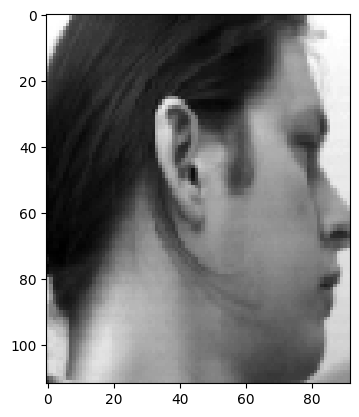

In [ ]:
## Load the data EXAMPLE 
data = sio.loadmat('umist_cropped.mat')
facedat = data['facedat']

first_person = facedat[0]

test = first_person[0]

test1 = test[:, :, 0]

plt.imshow(test1, cmap='gray')
plt.show()






In [ ]:
## Split Data into Validation, Training and Testing using stratified sampling
from sklearn.model_selection import train_test_split


In [ ]:
## Preprocess the data
## Normalize the data


In [ ]:
## Training

<b><h2 style="margin-bottom:0px;">Analysis Report</h2></b>

2. In the analysis report, discuss the rationale behind how your team preprocess the data. Include the mathematical equations used and any dimensionality reduction applied to the instanced and discuss its relevance to the problem at hand. (Note that your team will receive more points if you perform data preprocessing that help improve the eventual training process.)

Lorem ipsum dolor sit amet consectetur adipisicing elit. Labore eveniet, reiciendis necessitatibus minus corporis cum consequatur laboriosam vero provident totam autem voluptate, non saepe exercitationem dolorum rem quae officiis quaerat consequuntur est laborum ea tempora officia incidunt. Facere, explicabo eaque. Nam aliquid repellat facilis, molestiae aspernatur perferendis minus. Voluptas explicabo velit, porro, et, voluptatem accusantium dicta nulla perferendis quia ad aut? Voluptates odio voluptatibus dolorum excepturi! Laborum magni consequatur tenetur voluptatem velit atque dolorum consectetur. Incidunt natus est provident? Reprehenderit cum ipsum quod? Repudiandae illo iure dolorum amet esse praesentium, obcaecati magni dolores perferendis omnis, deleniti placeat velit corrupti cum nulla est reprehenderit rerum laudantium, ad quos expedita fuga qui. At quas, repudiandae, eos iusto excepturi consequatur nisi perferendis voluptatibus velit distinctio hic deleniti nihil, suscipit doloribus non sapiente. Rerum incidunt impedit provident voluptas consectetur deserunt, consequuntur dicta. In, at consectetur quia mollitia incidunt expedita impedit? Numquam dignissimos, tenetur itaque saepe obcaecati quam voluptatum blanditiis debitis officia accusantium, reiciendis corporis fugiat voluptates vel magni quibusdam, odit id? Tenetur sit aspernatur soluta deserunt aut laboriosam qui? Commodi laboriosam fugiat reiciendis temporibus in nemo consequuntur, assumenda, ipsam repudiandae ullam porro consequatur saepe hic dolore eum omnis perspiciatis eos ratione quas labore dicta?

<b><h2 style="margin-bottom:0px;">Clustering</h2></b>

3. Select a clustering technique taught in this course and apply it on the training instances. Provide the rationale behind your team’s choice of clustering technique and how your team tuned the parameters for the technique implemented. 

In [ ]:
## Clustering
    ## JAMES - DBSCAN

    ## ALI - Gaussian Mixture

    ## Garnett - DBSCAN




<b><h2 style="margin-bottom:0px;">Analysis Report - Architecture</h2></b>

4. In the analysis report, clearly discuss - with illustrations - the architecture your team has selected for training and predicting the test instances. Discuss the rationale behind your team’s choice of activation functions, loss function, and how you tuned the hyperparameters of the network model.

Lorem ipsum dolor sit amet consectetur, adipisicing elit. Accusamus voluptatum repudiandae, magnam ab animi voluptates in veritatis ad optio dicta perferendis fuga non placeat libero corporis blanditiis deserunt eos commodi aliquid atque debitis. Illo officia hic ad neque optio consequuntur dolores enim quibusdam unde libero sint ea facere, repudiandae dignissimos voluptatem cupiditate ipsa consectetur magni aperiam ullam quod culpa animi nostrum est! Eos, voluptatibus asperiores? Assumenda cupiditate omnis rerum doloribus, inventore dolore vero quam alias reiciendis illum earum quisquam, officia ex, tempora iusto sit! Vitae repudiandae exercitationem accusamus? Mollitia autem iure recusandae odio vero harum, quis ipsa! Quidem, facilis placeat!

<b><h2 style="margin-bottom:0px;">Results</h2></b>

5. Discuss the results of the trained system in the report.

Lorem ipsum dolor sit amet consectetur, adipisicing elit. Quidem laborum maiores ab ducimus repellat deleniti nesciunt aliquid error sequi et. Natus pariatur magni mollitia, aspernatur harum molestias dolorem. Laudantium optio quos ut blanditiis quidem delectus ea possimus. Ea voluptatibus, nisi magni alias officia aut beatae mollitia eum dolore quasi exercitationem doloribus similique minima doloremque autem adipisci atque ullam aspernatur dolor repellat quis nam inventore tempore! Illum cupiditate fuga, cum tenetur ipsa voluptatibus totam iusto amet ad itaque debitis sed veritatis ipsum magnam corporis vel voluptatem nulla. Voluptatum dolor incidunt molestiae laborum modi ut sed. Placeat, ad? Deleniti ex possimus illo veritatis modi. Vitae voluptatibus laborum, quidem quod nostrum incidunt dolorem libero rem officia eos mollitia fuga non iusto vero architecto repellat, ex at exercitationem cumque autem cum. Eius natus tempora dolorem quos eos cupiditate exercitationem assumenda praesentium incidunt sed dolor similique quidem optio labore illo, quam ex nihil corporis impedit minus fuga fugit enim harum maxime. Animi architecto, rem necessitatibus quas ratione nulla sapiente doloremque veniam recusandae quasi aliquam! Facere ad eos nemo dolores pariatur, quo quas. Nulla, fugit. Consequatur quas dolor, laboriosam nesciunt aspernatur exercitationem illum enim tempore atque magnam in! Aut quam voluptate consequuntur inventore provident et quisquam, laboriosam fugit hic sunt at natus a soluta consequatur quidem animi. Odio sed labore amet, officiis reiciendis in incidunt est voluptatibus consequatur omnis sequi optio mollitia tenetur non voluptas ducimus! Unde et sint officia recusandae, veniam nemo qui nisi! Odio, molestias vel sit porro ut

<b><h2 style="margin-bottom:0px;">Demo</h2></b>

6. Demonstrate the project as a Team. In the analysis report, discuss the decisions your team made, the challenges your team encountered, how your team resolved the problems, and the results.

Lorem ipsum dolor, sit amet consectetur adipisicing elit. Inventore totam voluptates eos magni sequi fugit ab. Maxime fugiat blanditiis non beatae inventore corporis rem exercitationem molestias aspernatur consequatur expedita eos ducimus veritatis, odit iure rerum, at cumque vel debitis, optio culpa! In veniam ipsam quod dignissimos cumque vitae aut voluptates, dolorum nobis animi alias est dolor eum sit provident ut suscipit nostrum, blanditiis sunt veritatis recusandae quibusdam doloremque! Labore earum laboriosam temporibus maiores distinctio natus? Beatae nulla, aliquid natus consequuntur cum sunt error deserunt qui molestias culpa, quisquam, aliquam voluptatem! Atque quaerat blanditiis velit vitae porro ipsum eum iste tempora.